In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import latools as la

In [6]:
d = la.analyse('egdata')

Starting analysis using "UCD-AGILENT" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba137 Ba138
  Internal Standard: Ca43


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

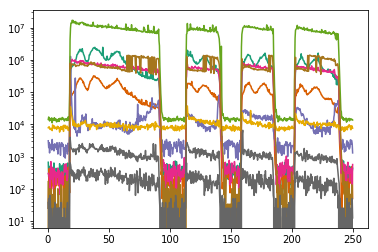

In [17]:
fig, ax = plt.subplots(1,1)

sample = 'Sample-1'
focus = 'rawdata'
for a in d.analytes:
    di = d.data[sample]
    ax.plot(di.Time, di.data[focus][a], c=di.cmap[a])

ax.set_yscale('log')

In [21]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def artificial_data(tstep=0.1, tmax=300, washout=-2.5, nsig=1, spikes=0):
    out = {}
    out['time'] = np.arange(0, tmax, tstep)
    npoints = out['time'].size
    
    laser_on = np.random.uniform(0, tmax/3, 1)
    laser_off = np.random.uniform(2 * tmax / 3,  tmax, 1)
    
    i_laser_on = np.where(abs(out['time'] - laser_on) == min(abs(out['time'] - laser_on)))
    i_laser_off = np.where(abs(out['time'] - laser_off) == min(abs(out['time'] - laser_off)))
    
    for n in range(nsig):
        sig = np.zeros(npoints)
        
        # signal intensity
        intens = np.random.uniform(0, 1e5, 1)
        # assign laser on region
        sind = (out['time'] > laser_on) & (out['time'] < laser_off)
        # signal that decreases with time
        ssig = intens - intens * 0.0005 * out['time'][:sum(sind)]
        sig[sind] = ssig
        endintens = min(ssig)
        
        # washout
        wind = out['time'] > laser_off
        ttail = out['time'][:sum(wind)]
        sig[wind] = endintens * np.exp(washout * ttail)
        
        # flush
        find = out['time'] < laser_on
        tflush = out['time'][:sum(find)][::-1]
        sig[find] = intens * np.exp(3 * washout * tflush)
        
        bkg = np.random.uniform(0, 1e3, 1)
        bkg_std = bkg * np.random.uniform(0, 2, 1)
        sig += np.random.normal(bkg, bkg_std, npoints)
        
        if spikes > 0:
            spind = np.random.randint(0, npoints - 1, spikes)
            sig[spind] = np.random.uniform(0.1 * intens, 5 * intens, spikes)
            
        out['s{}'.format(n)] = sig
    
    return out

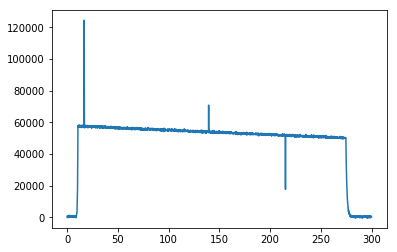

In [24]:
np.random.seed(124)

d = artificial_data(washout=-1, spikes=3)
plt.plot(d['time'], d['s0'])

In [25]:
time = d['time']
tstep = time[1] - time[0]
sig = d['s0']
expdecay_coef = -1

signew = sig.copy()
sigvec = sig.copy()

In [26]:
%%time
# calculate signal noise from first 20 points
sigstart = sig[:20]
rms_noise = np.std(sigstart)

# remove high points in first pass
for i in range(len(time) - 1):
    v = signew[i]
    vnext = signew[i+1]
    
    vdec = v * np.exp(tstep * expdecay_coef)
    vmin = vdec - rms_noise * 3
    
    if vnext < vmin:
        signew[i] = vnext

# remove low points in second pass
for i in range(len(time) - 1):
    v = signew[i]
    vnext = signew[i+1]
    
    vdec = v * np.exp(tstep * expdecay_coef)
    vmin = vdec - rms_noise * 3
    
    if vnext < vmin:
        signew[i+1] = v

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 17.5 ms


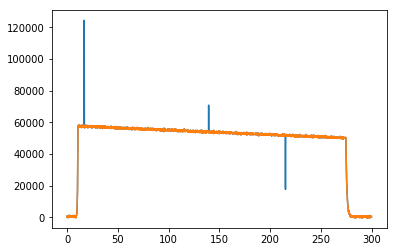

In [27]:
plt.plot(time, sig)
plt.plot(time, signew)

# plt.xlim(0, 10)
# plt.ylim(0, 10000)

## vectorise

In [28]:
%%time
# spikes = np.zeros(len(sig), dtype=bool)

ic = 5
noise = np.std(sig[:5])
for i in [10, 20, 30, 50]:
    inoise = np.std(sig[:i])
    if inoise < 1.5 * noise:
        noise = inoise
        ic = i
    
rms_noise3 = 3 * noise

# sigstart = sig[:20]
# rms_noise3 = 3 * np.std(sigstart)

siglo = np.roll(sig * np.exp(tstep * expdecay_coef), 1)
sighi = np.roll(sig * np.exp(-tstep * expdecay_coef), -1)

loind = (sig < siglo - rms_noise3) & (sig < np.roll(sig, -1) - rms_noise3)
hiind = (sig > sighi + rms_noise3) & (sig > np.roll(sig, 1) + rms_noise3)

sigvec[loind] = sigvec[np.roll(loind, -1)]
sigvec[hiind] = sigvec[np.roll(hiind, -1)]

CPU times: user 946 µs, sys: 0 ns, total: 946 µs
Wall time: 819 µs


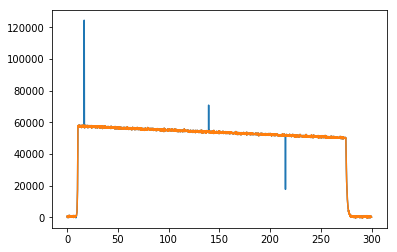

In [29]:
plt.plot(time, sig)
plt.plot(time, sigvec)

# plt.plot(time, np.roll(sig, -1))

# for lo in np.where(loind)[0]:
#     plt.axvline(time[lo], c='g')

# for hi in np.where(hiind)[0]:
#     plt.axvline(time[hi], c='r')

# plt.xlim(95,110)

### Test New Function

In [30]:
from latools.helpers.process_fns import expdecay_despike

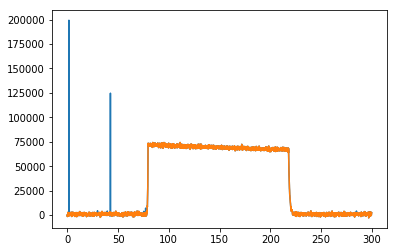

In [36]:
washout = -1
d = artificial_data(washout=washout, spikes=3)

os = d['s0'].copy()

ns = expdecay_despike(d['s0'], washout, d['time'][1] - d['time'][0])

plt.plot(d['time'], os)
plt.plot(d['time'], ns)